In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# default_exp preprocessing
pass # xpython fix

# Preprocessing functions for images stored in lmmdb

There are two types of preprocessing functions: intra-image, and inter-image. Intra-image functions use data from one image, and its mask. Inter-image functions use data from the entire database, e.g. per-pixel mean centering. Take care to only apply inter-image funcitions AFTER train-test-validation splitting.

> API

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
# export
from ifcimglib import imglmdb, utils
import numpy
import matplotlib.pyplot as plt
import cv2
from tqdm import trange, tqdm
import seaborn

In [5]:
db = imglmdb.imglmdb("/mnt/d/Experiment_data/newcastle/wbc/focused/BD lyse fix 3_3_Focused & Singlets & CD45 pos.lmdb")
db

db BD lyse fix 3_3_Focused & Singlets & CD45 pos.lmdb, length 25227, channels 

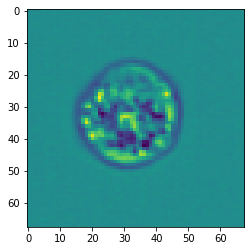

In [6]:
sample_img, sample_mask = db.get_image(0)
sample_img = sample_img.astype(numpy.float32)
plt.imshow(sample_img[0])

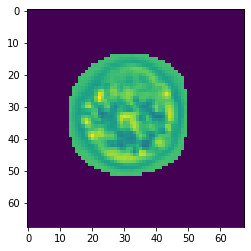

In [7]:
plt.imshow(sample_img[0]*sample_mask[0])

## Intra-image functions

In [18]:
# export
def log_transform(x, m, channels):
    x[channels] = numpy.where(x[channels] == 0.0, 1.0, x[channels])
    x[channels] = numpy.log(x[channels])
    return x

/home/maximl/.conda/envs/ml/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


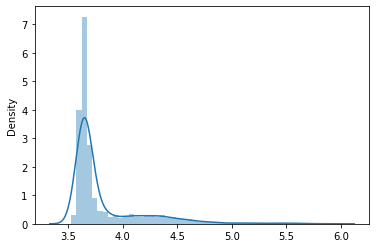

In [19]:
seaborn.distplot(log_transform(sample_img, sample_mask, [1])[1])

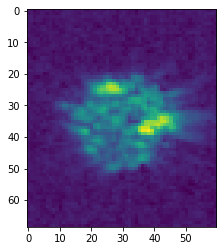

In [20]:
plt.imshow(log_transform(sample_img, sample_mask, [1])[1])

In [21]:
# export
def min_max_normalize(x, m, post_norm):
    if not post_norm in ["zero", "mean", "no", "clip"]:
        raise ValueError("%s not recognized." % post_norm)

    if m is None:
        flat_x = x.reshape(x.shape[0], -1)
        mi = flat_x.min(axis=1)
        ma = flat_x.max(axis=1)
    else:
        x_copy = x.copy()
        x_copy[~m] = numpy.nan
        flat_x = x_copy.reshape(x_copy.shape[0], -1)

        nan_check = numpy.isnan(flat_x).all(axis=1)
        if nan_check.any():
            flat_x[nan_check] = 0.0

        mi = numpy.nanmin(flat_x, axis=1)
        ma = numpy.nanmax(flat_x, axis=1)

    denom = ma - mi
    denom[denom <= 0.0] = 1.0

    normed = ((x.T-mi)/denom).T

    if numpy.isnan(normed).any():
        raise ValueError("normed contains nan")
    if numpy.isinf(normed).any():
        raise ValueError("normed contains inf")

    if m is not None:
        if post_norm == "mean":
            for i in range(normed.shape[0]):
                if m[i].any():
                    me = numpy.mean(normed[i][m[i]])
                    if numpy.isnan(me):
                        raise ValueError("here", me)
                    if (~m[i]).any():
                        normed[i][~m[i]] = me
        elif post_norm == "zero":
            normed[~m] = 0.0
        elif post_norm == "clip":
            normed = numpy.clip(normed, 0, 1)

    return normed

1.0 0.0 0.30923837


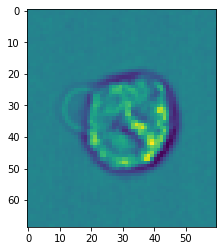

In [22]:
norm_sample_img = min_max_normalize(sample_img, sample_mask, "clip")
plt.imshow(norm_sample_img[0])
print(norm_sample_img.max(), norm_sample_img.min(), norm_sample_img.mean())

In [23]:
# export
def crop_and_pad_to_square(x, desired_size):
    x = numpy.swapaxes(x, 0, -1)

    old_size = x.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(a*ratio) for a in old_size])

    x = cv2.resize(x, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    return numpy.swapaxes(cv2.copyMakeBorder(x, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color), -1, 0)

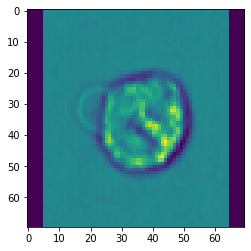

In [24]:
cropped_sample_img = crop_and_pad_to_square(norm_sample_img, 70)
plt.imshow(cropped_sample_img[0])

## Inter-image functions

In [25]:
# export
def compute_per_pixel_stats(db, shape, do_preprocess_steps=False, idx=None):
    # according to http://proceedings.mlr.press/v28/wan13.html

    idx = numpy.arange(len(db)) if idx is None else idx

    if shape is None:
        shape = db.get_image(idx[0])[0].shape

    s = numpy.zeros(shape, dtype=numpy.float32)
    n = 0.0

    for i in tqdm(idx):
        x, m, _ = db.get_image(i)

        if do_preprocess_steps:
            x = x.astype(numpy.float32)
            x = log_transform(x, m, [1])
            x = min_max_normalize(x, m, "clip")
            x = crop_and_pad_to_square(x, 70)

        s += x
        n += 1

    mean = s / n

    s = numpy.zeros(shape, dtype=numpy.float32)
    for i in tqdm(idx):
        x, m, _ = db.get_image(i)

        if do_preprocess_steps:
            x = x.astype(numpy.float32)
            x = min_max_normalize(x, m, "clip")
            x = crop_and_pad_to_square(x, 70)

        s += (x - mean)**2

    s = numpy.sqrt(s/n)

    return mean, s

In [26]:
per_pixel_stats = compute_per_pixel_stats(db, cropped_sample_img.shape, do_preprocess_steps=True)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
std_per_pixel = numpy.where(per_pixel_stats[1] == 0.0, 1, per_pixel_stats[1])

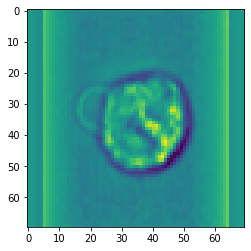

In [ ]:
per_pixel_centered_sample_img = (cropped_sample_img - per_pixel_stats[0])/std_per_pixel
plt.imshow(per_pixel_centered_sample_img[0])

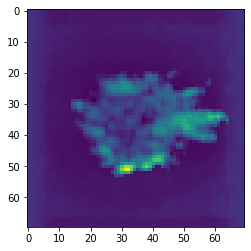

In [ ]:
plt.imshow(per_pixel_centered_sample_img[1])

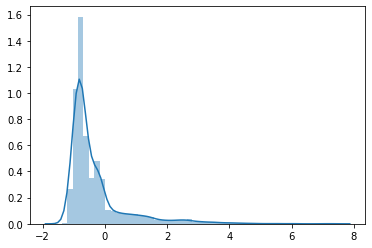

In [ ]:
seaborn.distplot(per_pixel_centered_sample_img[1])